In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [2]:
true=pd.read_csv('datasets/True.csv')
fake=pd.read_csv('datasets/Fake.csv')

In [3]:
#Add label column
true['label']=1
fake['label']=0

In [4]:
#merge dataframes
df=pd.concat([true,fake],axis=0)

In [5]:
# shuffle dataframe
data=df.sample(frac=1).reset_index(drop=True)

In [6]:
data

,title,text,subject,date,label
0,This Expert Just Shut Down Every Claim That T...,There should be no doubt that racism is very m...,News,"May 29, 2016",0
1,Aggressive cuts to Obama-era green rules to st...,(Reuters) - U.S. President Donald Trump’s admi...,politicsNews,"February 25, 2017",1
2,Bernie Sanders SKEWERS Trump And Cruz For The...,While the Republican presidential candidates h...,News,"March 22, 2016",0
3,"Liberal, conservative lawmakers offer opposing...",WASHINGTON (Reuters) - U.S. senators unveiled ...,politicsNews,"September 13, 2017",1
4,Hungary's opposition Socialists lose PM candid...,BUDAPEST (Reuters) - The Hungarian Socialist P...,worldnews,"October 2, 2017",1
...,...,...,...,...,...
44893,"KID ROCK GOES OFF On Colin Kaepernick, Obamaca...",Kid Rock hasn t officially announced his run f...,left-news,"Sep 14, 2017",0
44894,[VIDEO] OBAMA TELLS HOMETOWN KENYANS: “I’m A P...,"We re not sure what s funnier, the fact that h...",left-news,"Jul 28, 2015",0
44895,Trump supporters praise softer tone in address...,"CLEARWATER, Fla. (Reuters) - While U.S. Presid...",politicsNews,"March 1, 2017",1
44896,Joint Strike Fighter plans stolen in Australia...,SYDNEY (Reuters) - A hacker stole non-classifi...,worldnews,"October 12, 2017",1


In [7]:
#merge text with title only if title is not null
data['text'] = data['title'].fillna('') + data['text'].fillna('')

In [8]:
# remove title, subject and date
data.drop(['title','subject','date'],axis=1,inplace=True)

In [9]:
data

,text,label
0,This Expert Just Shut Down Every Claim That T...,0
1,Aggressive cuts to Obama-era green rules to st...,1
2,Bernie Sanders SKEWERS Trump And Cruz For The...,0
3,"Liberal, conservative lawmakers offer opposing...",1
4,Hungary's opposition Socialists lose PM candid...,1
...,...,...
44893,"KID ROCK GOES OFF On Colin Kaepernick, Obamaca...",0
44894,[VIDEO] OBAMA TELLS HOMETOWN KENYANS: “I’m A P...,0
44895,Trump supporters praise softer tone in address...,1
44896,Joint Strike Fighter plans stolen in Australia...,1


In [10]:
def preprocess_text(text):
    # remove the text with garbage values like emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # remove the text with html tags
    text = re.sub(r'<.*?>', '', text)

    # remove the text with url or links like http or www
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)

    # convert to lower case
    text = text.lower()

    # remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # remove special characters
    text = re.sub(r'\W+', ' ', text)

    text = re.sub(r'\s+', ' ', text)
    return text

data['text'] = data['text'].apply(preprocess_text)

In [11]:
# check if any text column strings length is less than 3
data[data['text'].str.len() < 25]

,text,label
11,,0
13034,,0
15454,,0
16009,,0
16785,,0
19898,,0
28337,,0
32317,,0
43200,,0


In [12]:
# drop rows with text length less than 3
data = data.drop(data[data['text'].str.len() < 25].index)

In [13]:
# count empty cells in text column
data.isnull().sum()

text     0
label    0
dtype: int64

In [14]:
# save the data set to new csv file
data.to_csv('datasets/Preprocessed_data.csv', index=False)

In [63]:
# Standard library imports
import multiprocessing
import pickle

# Third party imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Attention, Flatten, Input, Concatenate, Reshape, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [17]:
# Load the dataset
df = pd.read_csv('datasets/Preprocessed_data.csv')

# Split the dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
def make_tagged_document(df):
    """
    Create a list of tagged documents from a dataframe
    """
    # Create an empty list for storing tagged documents
    tagged_documents = []

    # Iterate over the rows of the data frame
    for index, row in df.iterrows():
        # Get the text and the label from the row
        texts = str(row['text'])
        labels = str(row['label'])

        # Split the text into a list of words
        words = texts.split()

        # Create a list of tags using the index and the label
        tags = [str(index), labels]

        # Create a tagged document object
        tagged_document = TaggedDocument(words=words, tags=tags)

        # Append the tagged document to the list
        tagged_documents.append(tagged_document)

    # Return the list of tagged documents
    return tagged_documents

In [19]:
# Create tagged documents from the preprocessed text data
tagged_train_documents = make_tagged_document(train_df)
tagged_test_documents = make_tagged_document(test_df)

# Word Embedding with doc2Vec

In [21]:
# Use all available CPU cores
cores = multiprocessing.cpu_count()

# Create a Doc2Vec model with vector size 100
model = Doc2Vec(vector_size=100, min_count=2, epochs=40, workers=cores)

# Build a vocabulary from the training set
model.build_vocab(tagged_train_documents)

# Train the Doc2Vec model
model.train(tagged_train_documents, total_examples=model.corpus_count, epochs=model.epochs)

In [22]:
model.save("models/doc2vec.model")

<h3> Inferriing vector representation for each document -- vectorization </h3>

In [23]:
# Infer the feature representation for test documents
X_train = [model.infer_vector(eval(str(doc.words))) for doc in tagged_train_documents]
X_test = [model.infer_vector(eval(str(doc.words))) for doc in tagged_test_documents]

In [24]:
# Get the labels for the training and test data
y_test = [doc.tags[1] for doc in tagged_test_documents]
y_train = [doc.tags[1] for doc in tagged_train_documents]

# Classificaiton models

# Logistic Regression

In [36]:
# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

In [37]:
# Calculate the accuracy score on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the F1 score on the test set
print("classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9838494096680775
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4753
           1       0.98      0.98      0.98      4225

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978



# SUPPORT VECTOR MACHINE

In [38]:
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)
svm_classifier.fit(X_train, y_train)
y2_pred = svm_classifier.predict(X_test)

# Calculate the accuracy score on the test set
accuracy = accuracy_score(y_test, y2_pred)
print("Accuracy:", accuracy)

# Evaluate the model
print("classification report:")
print(classification_report(y_test, y2_pred))

Accuracy: 0.9847404767208733
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4753
           1       0.98      0.98      0.98      4225

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978



# BAYESIAN CLASSIFIER

In [39]:
# Train a Bayesian model
bayes_classifier = GaussianNB()
bayes_classifier.fit(X_train, y_train)

GaussianNB()

In [40]:

y3_pred = bayes_classifier.predict(X_test)

# Calculate the accuracy score on the test set
accuracy = accuracy_score(y_test, y3_pred)
print("Accuracy:", accuracy)

# Evaluate the model
print("classification report:")
print(classification_report(y_test, y3_pred))

Accuracy: 0.9501002450434395
classification report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      4753
           1       0.92      0.98      0.95      4225

    accuracy                           0.95      8978
   macro avg       0.95      0.95      0.95      8978
weighted avg       0.95      0.95      0.95      8978



# Bagging

In [41]:
# Train a Baggging model
bagging_classifier = BaggingClassifier()
bagging_classifier.fit(X_train, y_train)
y4_pred = bagging_classifier.predict(X_test)

# Calculate the accuracy score on the test set
accuracy = accuracy_score(y_test, y4_pred)
print("Accuracy:", accuracy)

# Evaluate the model
print("classification report:")
print(classification_report(y_test, y4_pred))

Accuracy: 0.9320561372243261
classification report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4753
           1       0.95      0.90      0.93      4225

    accuracy                           0.93      8978
   macro avg       0.93      0.93      0.93      8978
weighted avg       0.93      0.93      0.93      8978



# Random Forest

In [42]:
# Train a Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y4_pred = rf_classifier.predict(X_test)

# Calculate the accuracy score on the test set
accuracy = accuracy_score(y_test, y4_pred)
print("Accuracy:", accuracy)

# Evaluate the model
print("classification report:")
print(classification_report(y_test, y4_pred))

Accuracy: 0.9731566050345288
classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4753
           1       0.98      0.96      0.97      4225

    accuracy                           0.97      8978
   macro avg       0.97      0.97      0.97      8978
weighted avg       0.97      0.97      0.97      8978



# Combine model using Voting

In [153]:
# Combine model using soft voting
estimators = []
estimators.append(('logistic', clf))
estimators.append(('svm', svm_classifier))
estimators.append(('randomforest', rf_classifier))
ensemble = VotingClassifier(estimators, voting='soft', weights=[1, 1, 1])

In [154]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression()),
                             ('svm', SVC(kernel='linear', probability=True)),
                             ('randomforest',
                              RandomForestClassifier(random_state=42))],
                 voting='soft', weights=[1, 1, 1])

In [155]:
y_pred = ensemble.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9862998440632658
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4753
           1       0.99      0.99      0.99      4225

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



In [156]:
# Save the models
filename = 'models/logistic.sav'
pickle.dump(clf, open(filename, 'wb'))

filename = 'models/svm.sav'
pickle.dump(svm_classifier, open(filename, 'wb'))

filename = 'models/bayes.sav'
pickle.dump(bayes_classifier, open(filename, 'wb'))

filename = 'models/bagging.sav'
pickle.dump(bagging_classifier, open(filename, 'wb'))

filename = 'models/randomforest.sav'
pickle.dump(rf_classifier, open(filename, 'wb'))

filename = 'models/voting.sav'
pickle.dump(ensemble, open(filename, 'wb'))

# Deep learning neural network model

In [47]:
# Convert the training and test input data to numpy arrays
X_train2 = np.array(X_train)
X_test2 = np.array(X_test)

# Initialize the LabelEncoder object
le = LabelEncoder()

# Fit and transform the training output data using the LabelEncoder
y_train2 = le.fit_transform(y_train)

# Transform the test output data using the LabelEncoder
y_test2 = le.transform(y_test)

# LSTM

In [53]:
# make a neural network model with LSTM that can be used with Doc2Vec representations
modLSTM = keras.Sequential()
modLSTM.add(Input(shape=(100,)))
modLSTM.add(Reshape((100, 1)))
modLSTM.add(LSTM(64))
modLSTM.add(Dropout(0.5))
modLSTM.add(Dense(1, activation='sigmoid'))

modLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modLSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 100, 1)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [54]:
LSTM_history = modLSTM.fit(X_train2, y_train2, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1123/1123 [==============================] - 21s 17ms/step - loss: 0.4536 - accuracy: 0.7826
Epoch 2/10
1123/1123 [==============================] - 19s 17ms/step - loss: 0.3038 - accuracy: 0.8713
Epoch 3/10
1123/1123 [==============================] - 19s 17ms/step - loss: 0.2094 - accuracy: 0.9186
Epoch 4/10
1123/1123 [==============================] - 19s 17ms/step - loss: 0.1570 - accuracy: 0.9416
Epoch 5/10
1123/1123 [==============================] - 19s 17ms/step - loss: 0.1316 - accuracy: 0.9515
Epoch 6/10
1123/1123 [==============================] - 19s 17ms/step - loss: 0.1187 - accuracy: 0.9564
Epoch 7/10
1123/1123 [==============================] - 19s 17ms/step - loss: 0.1060 - accuracy: 0.9617
Epoch 8/10
1123/1123 [==============================] - 19s 17ms/step - loss: 0.0920 - accuracy: 0.9659
Epoch 9/10
1123/1123 [==============================] - 19s 17ms/step - loss: 0.0807 - accuracy: 0.9707
Epoch 10/10
1123/1123 [==============================] - 19s 17m

In [159]:
# test accuracy and loss
test_loss, test_accuracy = modLSTM.evaluate(X_test2, y_test2, verbose=1)
print("Test accuracy:", test_accuracy)

y_pred = modLSTM.predict(X_test2)
y_pred = np.round(y_pred).astype(int)
print("classification report:")
print(classification_report(y_test2, y_pred))

281/281 [==============================] - 2s 9ms/step - loss: 0.0947 - accuracy: 0.9658
Test accuracy: 0.9658052921295166
281/281 [==============================] - 2s 7ms/step
classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4753
           1       0.96      0.97      0.96      4225

    accuracy                           0.97      8978
   macro avg       0.97      0.97      0.97      8978
weighted avg       0.97      0.97      0.97      8978



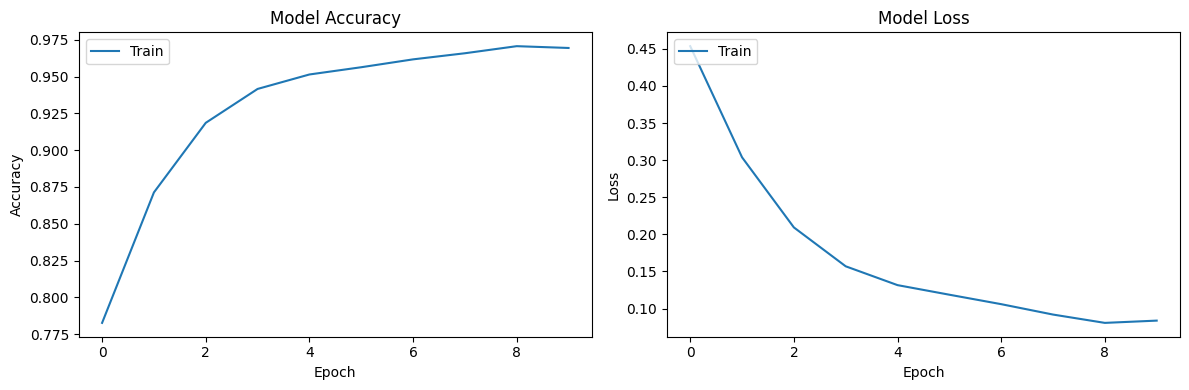

In [98]:
# Plot the accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(LSTM_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(LSTM_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

# Bi LSTM

In [59]:
# Define a neural network model with Bi-LSTM that can be used with Doc2Vec representations
modBiLSTM = keras.Sequential()
modBiLSTM.add(Input(shape=(100,)))
modBiLSTM.add(Reshape((100, 1)))
modBiLSTM.add(Bidirectional(keras.layers.LSTM(128)))
modBiLSTM.add(Dropout(0.5))
modBiLSTM.add(Dense(64, activation='relu'))
modBiLSTM.add(Dense(1, activation='sigmoid'))

# Compile the model
modBiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

modBiLSTM.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 100, 1)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              133120    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 149,633
Trainable params: 149,633
Non-trainable params: 0
________________________________________________

In [60]:
BiLSTM_history = modBiLSTM.fit(X_train2, y_train2, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1123/1123 [==============================] - 61s 53ms/step - loss: 0.3888 - accuracy: 0.8181
Epoch 2/10
1123/1123 [==============================] - 63s 57ms/step - loss: 0.2056 - accuracy: 0.9168
Epoch 3/10
1123/1123 [==============================] - 66s 59ms/step - loss: 0.1418 - accuracy: 0.9439
Epoch 4/10
1123/1123 [==============================] - 66s 59ms/step - loss: 0.1155 - accuracy: 0.9558
Epoch 5/10
1123/1123 [==============================] - 66s 59ms/step - loss: 0.0928 - accuracy: 0.9659
Epoch 6/10
1123/1123 [==============================] - 65s 58ms/step - loss: 0.0803 - accuracy: 0.9698
Epoch 7/10
1123/1123 [==============================] - 65s 57ms/step - loss: 0.0709 - accuracy: 0.9740
Epoch 8/10
1123/1123 [==============================] - 65s 58ms/step - loss: 0.0626 - accuracy: 0.9769
Epoch 9/10
1123/1123 [==============================] - 65s 58ms/step - loss: 0.0569 - accuracy: 0.9794
Epoch 10/10
1123/1123 [==============================] - 70s 63m

In [158]:
# test accuracy and loss
test_loss, test_accuracy = modBiLSTM.evaluate(X_test2, y_test2, verbose=1)
print("Test accuracy:", test_accuracy)

y_pred = modBiLSTM.predict(X_test2)
y_pred = np.round(y_pred).astype(int)
print("classification report:")
print(classification_report(y_test2, y_pred))

281/281 [==============================] - 6s 19ms/step - loss: 0.1078 - accuracy: 0.9650
Test accuracy: 0.9650256037712097
281/281 [==============================] - 5s 18ms/step
classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4753
           1       0.98      0.95      0.96      4225

    accuracy                           0.97      8978
   macro avg       0.97      0.96      0.96      8978
weighted avg       0.97      0.97      0.96      8978



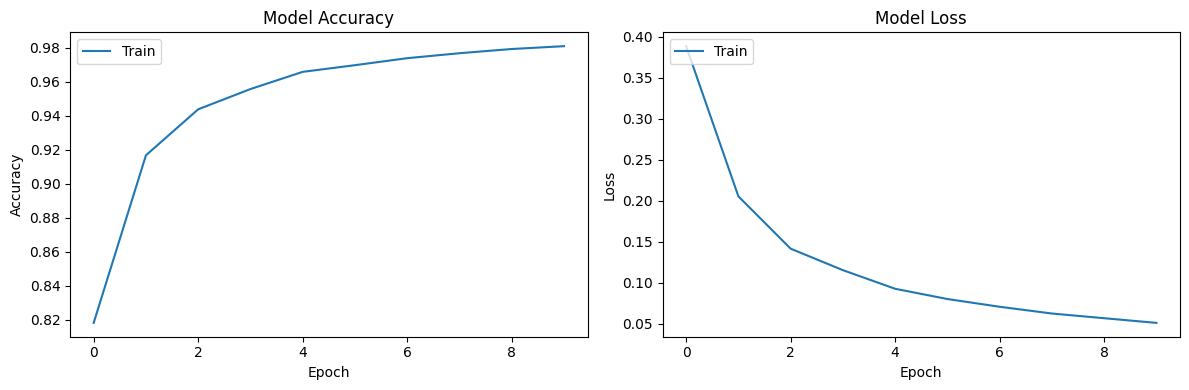

In [100]:
# Plot the accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(BiLSTM_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(BiLSTM_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

# CNN

In [80]:
# Define a neural network model with CNN that can be used with Doc2Vec representations
modCNN = keras.Sequential()
modCNN.add(Reshape((100, 1),input_shape=(100,)))
modCNN.add(Conv1D(128, 5, activation='relu', input_shape=(None, 100)))
modCNN.add(GlobalMaxPooling1D())
modCNN.add(Dense(64, activation='relu'))
# modCNN.add(Dropout(0.5))
modCNN.add(Dense(1, activation='sigmoid'))

modCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modCNN.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 100, 1)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 96, 128)           768       
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
___________________________________________________

In [81]:
CNN_history = modCNN.fit(X_train2, y_train2, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
1123/1123 - 5s - loss: 0.5600 - accuracy: 0.7057 - 5s/epoch - 5ms/step
Epoch 2/50
1123/1123 - 4s - loss: 0.5047 - accuracy: 0.7481 - 4s/epoch - 4ms/step
Epoch 3/50
1123/1123 - 4s - loss: 0.4903 - accuracy: 0.7620 - 4s/epoch - 4ms/step
Epoch 4/50
1123/1123 - 4s - loss: 0.4779 - accuracy: 0.7734 - 4s/epoch - 4ms/step
Epoch 5/50
1123/1123 - 4s - loss: 0.4673 - accuracy: 0.7813 - 4s/epoch - 3ms/step
Epoch 6/50
1123/1123 - 4s - loss: 0.4599 - accuracy: 0.7856 - 4s/epoch - 3ms/step
Epoch 7/50
1123/1123 - 4s - loss: 0.4573 - accuracy: 0.7896 - 4s/epoch - 4ms/step
Epoch 8/50
1123/1123 - 4s - loss: 0.4508 - accuracy: 0.7903 - 4s/epoch - 4ms/step
Epoch 9/50
1123/1123 - 4s - loss: 0.4438 - accuracy: 0.7939 - 4s/epoch - 4ms/step
Epoch 10/50
1123/1123 - 4s - loss: 0.4414 - accuracy: 0.7943 - 4s/epoch - 3ms/step
Epoch 11/50
1123/1123 - 4s - loss: 0.4384 - accuracy: 0.7960 - 4s/epoch - 3ms/step
Epoch 12/50
1123/1123 - 4s - loss: 0.4311 - accuracy: 0.8002 - 4s/epoch - 4ms/step
Epoch 13/50
1

In [157]:
# test accuracy and loss
test_loss, test_accuracy = modCNN.evaluate(X_test2, y_test2, verbose=1)
print("Test accuracy:", test_accuracy)

y_pred = modCNN.predict(X_test2)
y_pred = np.round(y_pred).astype(int)
print("classification report:")
print(classification_report(y_test2, y_pred))

281/281 [==============================] - 1s 2ms/step - loss: 0.4660 - accuracy: 0.7788
Test accuracy: 0.7787926197052002
281/281 [==============================] - 1s 3ms/step
classification report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      4753
           1       0.74      0.81      0.77      4225

    accuracy                           0.78      8978
   macro avg       0.78      0.78      0.78      8978
weighted avg       0.78      0.78      0.78      8978



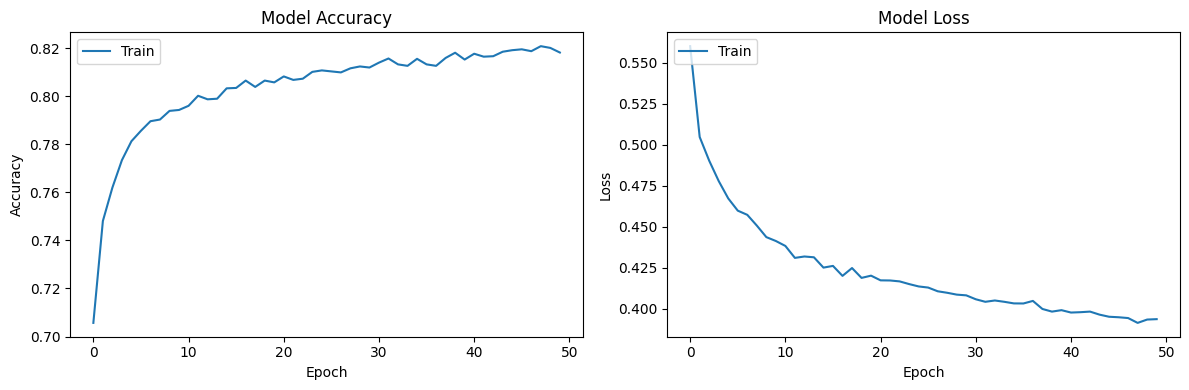

In [101]:
# Plot the accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(CNN_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(CNN_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

# GRU

In [128]:
# Define GRU model that can be used with Doc2Vec representations
modGRU = keras.Sequential()
modGRU.add(keras.layers.Input(shape=(100,)))
modGRU.add(keras.layers.Reshape((100, 1)))
modGRU.add(keras.layers.GRU(128, return_sequences=True))
modGRU.add(keras.layers.GRU(64))
modGRU.add(keras.layers.Dense(64, activation='relu'))
modGRU.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
modGRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modGRU.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_27 (Reshape)        (None, 100, 1)            0         
                                                                 
 gru_2 (GRU)                 (None, 100, 128)          50304     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_48 (Dense)            (None, 64)                4160      
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 91,777
Trainable params: 91,777
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Train the model
GRU_history = modGRU.fit(X_train2, y_train2, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


1123/1123 [==============================] - 57s 49ms/step - loss: 0.4117 - accuracy: 0.8038
Epoch 2/10
1123/1123 [==============================] - 55s 49ms/step - loss: 0.2168 - accuracy: 0.9132
Epoch 3/10
1123/1123 [==============================] - 54s 48ms/step - loss: 0.1385 - accuracy: 0.9466
Epoch 4/10
1123/1123 [==============================] - 55s 49ms/step - loss: 0.1039 - accuracy: 0.9612
Epoch 5/10
1123/1123 [==============================] - 56s 50ms/step - loss: 0.0798 - accuracy: 0.9704
Epoch 6/10
1123/1123 [==============================] - 58s 51ms/step - loss: 0.0632 - accuracy: 0.9767
Epoch 7/10
1123/1123 [==============================] - 56s 50ms/step - loss: 0.0542 - accuracy: 0.9807
Epoch 8/10
1123/1123 [==============================] - 56s 50ms/step - loss: 0.0480 - accuracy: 0.9824
Epoch 9/10
1123/1123 [==============================] - 56s 50ms/step - loss: 0.0390 - accuracy: 0.9855
Epoch 10/10
1123/1123 [==============================] - 56s 50ms/step - lo

In [97]:
test_loss, test_accuracy = modGRU.evaluate(X_test2, y_test2, verbose=1)
print("Test accuracy:", test_accuracy)

y_pred = modGRU.predict(X_test2)
y_pred = np.round(y_pred).astype(int)
print("classification report:")
print(classification_report(y_test2, y_pred))

281/281 [==============================] - 4s 14ms/step - loss: 0.1085 - accuracy: 0.9628
Test accuracy: 0.9627979397773743
281/281 [==============================] - 4s 15ms/step
classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4753
           1       0.97      0.95      0.96      4225

    accuracy                           0.96      8978
   macro avg       0.96      0.96      0.96      8978
weighted avg       0.96      0.96      0.96      8978



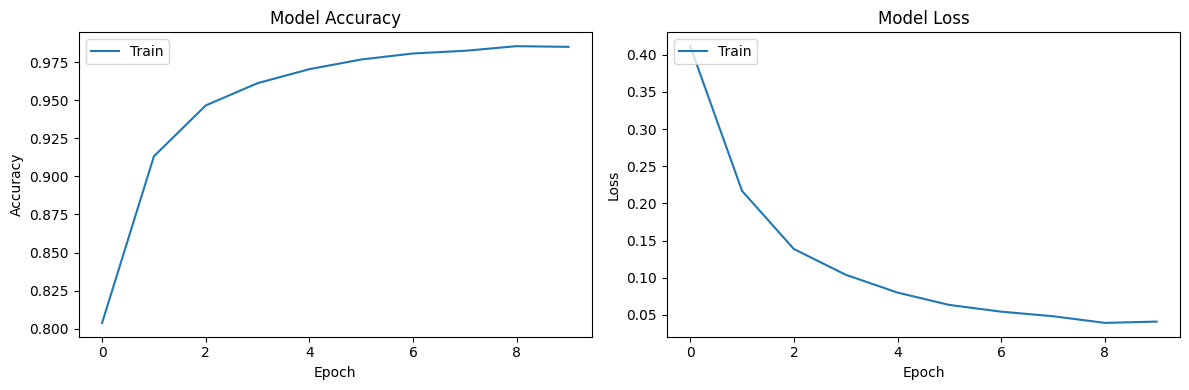

In [102]:
# Plot the accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(GRU_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(GRU_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

# Attention

In [123]:
# Define a neural network model using attention that can be used with Doc2Vec representations
query_input = Input(shape=(100,))
value_input = Input(shape=(100,))

query = Reshape((100, 1))(query_input)
value = Reshape((100, 1))(value_input)

attention_out = Attention()([query, value])
attention_out = Flatten()(attention_out)

out = Dense(64, activation='relu')(attention_out)
out = Dropout(0.5)(out)
out = Dense(1, activation='sigmoid')(out)

modAttention = keras.Model(inputs=[query_input, value_input], outputs=out)

# Compile the model
modAttention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modAttention.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 reshape_24 (Reshape)           (None, 100, 1)       0           ['input_25[0][0]']               
                                                                                                  
 reshape_25 (Reshape)           (None, 100, 1)       0           ['input_26[0][0]']               
                                                                                            

In [124]:
# To train the model we need to pass both the query and value inputs as the input to the model which is X_train2 twice
Att_history = modAttention.fit([X_train2, X_train2], y_train2, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1123/1123 [==============================] - 3s 2ms/step - loss: 0.1826 - accuracy: 0.9372
Epoch 2/10
1123/1123 [==============================] - 3s 2ms/step - loss: 0.0703 - accuracy: 0.9798
Epoch 3/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0518 - accuracy: 0.9851
Epoch 4/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0453 - accuracy: 0.9865
Epoch 5/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0375 - accuracy: 0.9882
Epoch 6/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0344 - accuracy: 0.9893
Epoch 7/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0305 - accuracy: 0.9905
Epoch 8/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0295 - accuracy: 0.9903
Epoch 9/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0281 - accuracy: 0.9910
Epoch 10/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.024

In [125]:
test_loss, test_accuracy = modAttention.evaluate([X_test2, X_test2], y_test2, verbose=1)
print("Test accuracy:", test_accuracy)

y_pred = modAttention.predict([X_test2, X_test2])
y_pred = np.round(y_pred).astype(int)
print("classification report:")
print(classification_report(y_test2, y_pred))

281/281 [==============================] - 1s 2ms/step - loss: 0.0693 - accuracy: 0.9846
Test accuracy: 0.9846290946006775
281/281 [==============================] - 1s 2ms/step
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4753
           1       0.99      0.98      0.98      4225

    accuracy                           0.98      8978
   macro avg       0.99      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978



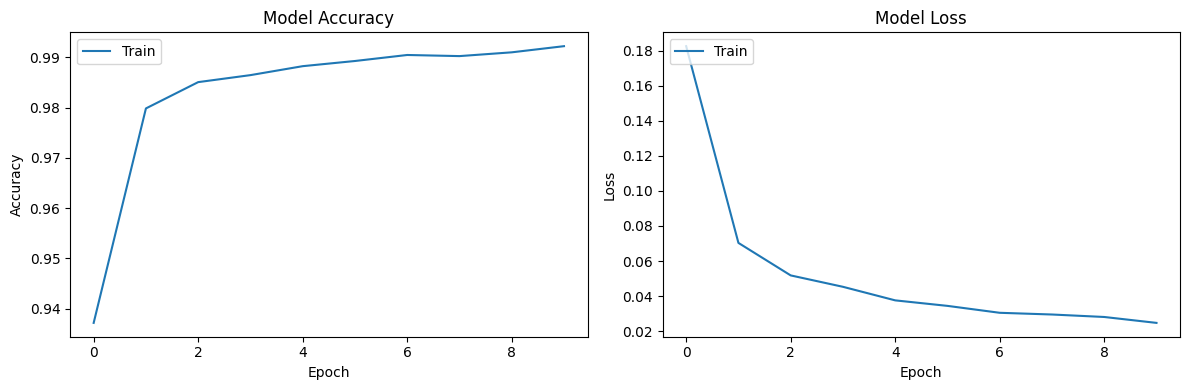

In [126]:
# Plot the accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(Att_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(Att_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

# Bi LSTM with CNN

In [127]:
# Define a hybrid neural network model of Bi-LSTM and CNN-text with droupout regulization technique that can be used with Doc2Vec representations
modBILSTMCNN = keras.Sequential()
modBILSTMCNN.add(keras.layers.Input(shape=(100,)))
modBILSTMCNN.add(keras.layers.Reshape((100, 1)))
modBILSTMCNN.add(keras.layers.Conv1D(128, 5, activation='relu'))
modBILSTMCNN.add(keras.layers.MaxPooling1D(pool_size=4))
modBILSTMCNN.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
modBILSTMCNN.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
modBILSTMCNN.add(keras.layers.Dense(64, activation='relu'))
modBILSTMCNN.add(keras.layers.Dropout(0.5))
modBILSTMCNN.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
modBILSTMCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modBILSTMCNN.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_26 (Reshape)        (None, 100, 1)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 96, 128)           768       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 24, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_12 (Bidirecti  (None, 24, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                     

In [86]:
BiLstmCnn = modBILSTMCNN.fit(X_train2, y_train2, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


1123/1123 [==============================] - 39s 31ms/step - loss: 0.1942 - accuracy: 0.9148
Epoch 2/10
1123/1123 [==============================] - 32s 28ms/step - loss: 0.0766 - accuracy: 0.9715
Epoch 3/10
1123/1123 [==============================] - 34s 30ms/step - loss: 0.0599 - accuracy: 0.9784
Epoch 4/10
1123/1123 [==============================] - 34s 31ms/step - loss: 0.0496 - accuracy: 0.9823
Epoch 5/10
1123/1123 [==============================] - 37s 33ms/step - loss: 0.0430 - accuracy: 0.9850
Epoch 6/10
1123/1123 [==============================] - 40s 35ms/step - loss: 0.0363 - accuracy: 0.9873
Epoch 7/10
1123/1123 [==============================] - 40s 35ms/step - loss: 0.0319 - accuracy: 0.9885
Epoch 8/10
1123/1123 [==============================] - 37s 33ms/step - loss: 0.0285 - accuracy: 0.9898
Epoch 9/10
1123/1123 [==============================] - 37s 33ms/step - loss: 0.0256 - accuracy: 0.9909
Epoch 10/10
1123/1123 [==============================] - 36s 32ms/step - lo

In [87]:
test_loss, test_accuracy = modBILSTMCNN.evaluate(X_test2, y_test2, verbose=1)
print("Test accuracy:", test_accuracy)

y_pred = modBILSTMCNN.predict(X_test2)
y_pred = np.round(y_pred).astype(int)
print("classification report:")
print(classification_report(y_test2, y_pred))

281/281 [==============================] - 3s 9ms/step - loss: 0.0906 - accuracy: 0.9771
Test accuracy: 0.977055013179779
281/281 [==============================] - 3s 9ms/step
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4753
           1       0.98      0.98      0.98      4225

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978



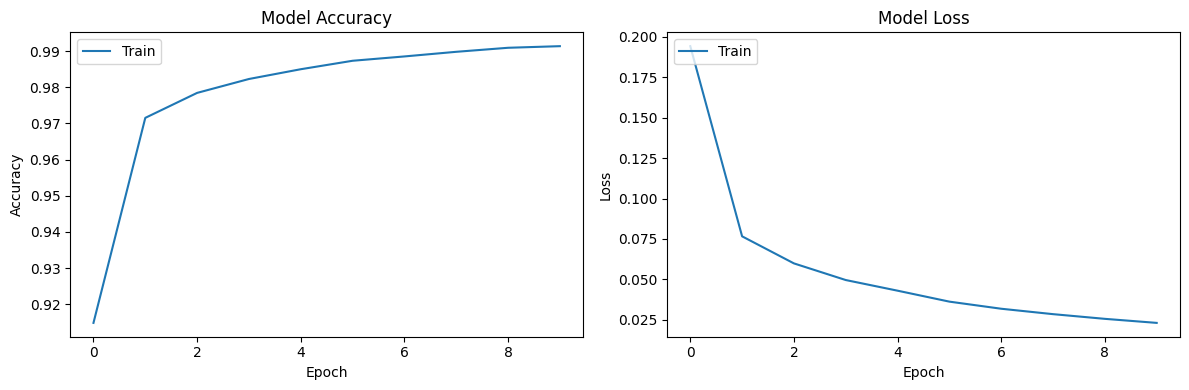

In [103]:
# Plot the accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(BiLstmCnn.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(BiLstmCnn.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

# Bi LSTM with Attention

In [89]:
input_layer = keras.layers.Input(shape=(100,))

# Reshape the input to match the expected shape of the LSTM layer
input_reshaped = keras.layers.Reshape((100, 1))(input_layer)

# Create the Bidirectional LSTM layers
lstm1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(input_reshaped) 
lstm2 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(lstm1)

# Project the output of the second LSTM layer to match the dimension of the first LSTM layer
lstm2_projected = keras.layers.Dense(256)(lstm2)

# Create the Attention layer
# Use the output of the first LSTM layer as the query tensor
# Use the projected output of the second LSTM layer as the value tensor
attention = keras.layers.Attention()([lstm1, lstm2_projected])

# Flatten the output of the Attention layer
attention_flattened = keras.layers.Flatten()(attention)

# Create the Dense layers
dense1 = keras.layers.Dense(64, activation='relu')(attention_flattened) 
dense2 = keras.layers.Dense(1, activation='sigmoid')(dense1)

# Create the model
modBiA = keras.Model(inputs=input_layer, outputs=dense2)

# Compile the model
modBiA.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modBiA.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 reshape_13 (Reshape)           (None, 100, 1)       0           ['input_14[0][0]']               
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 100, 256)    133120      ['reshape_13[0][0]']             
 )                                                                                                
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 100, 128)    164352      ['bidirectional_8[0][0]']  

In [90]:
# Train the model
BAH = modBiA.fit(X_train2, y_train2, epochs=3, batch_size=32, verbose=1)

Epoch 1/3


1123/1123 [==============================] - 136s 118ms/step - loss: 0.1038 - accuracy: 0.9513
Epoch 2/3
1123/1123 [==============================] - 136s 121ms/step - loss: 0.0295 - accuracy: 0.9896
Epoch 3/3
1123/1123 [==============================] - 137s 122ms/step - loss: 0.0251 - accuracy: 0.9915


In [91]:
test_loss, test_accuracy = modBiA.evaluate(X_test2, y_test2, verbose=1)
print("Test accuracy:", test_accuracy)

y_pred = modBiA.predict(X_test2)
y_pred = np.round(y_pred).astype(int)
print("classification report:")
print(classification_report(y_test2, y_pred))

281/281 [==============================] - 12s 41ms/step - loss: 0.0487 - accuracy: 0.9867
Test accuracy: 0.9867453575134277
281/281 [==============================] - 12s 39ms/step
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4753
           1       0.99      0.98      0.99      4225

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



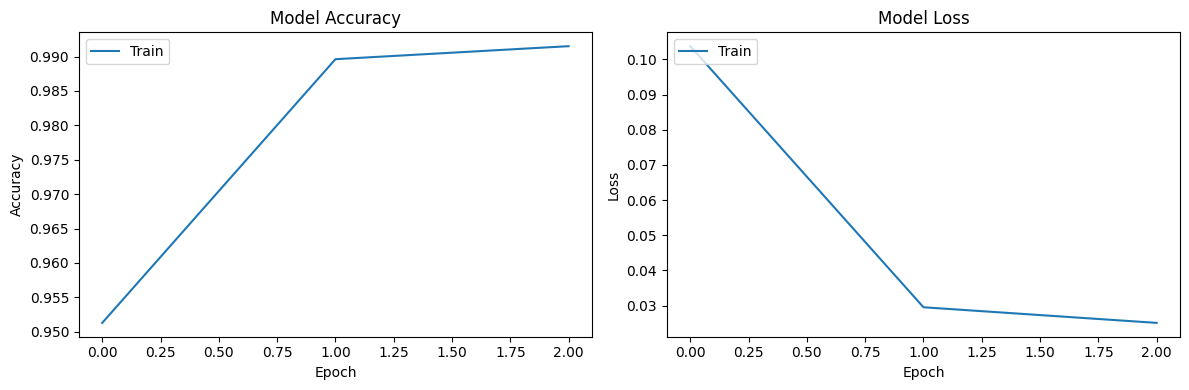

In [104]:
# Plot the accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(BAH.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(BAH.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

# CNN-Text droupout Bi-LSTM with and Attention

In [92]:
# CNN-Text Bi-LSTM with Attention and droupout
input_layer = keras.layers.Input(shape=(100,))
input_reshaped = keras.layers.Reshape((100, 1))(input_layer)
conv1 = keras.layers.Conv1D(128, 5, activation='relu')(input_reshaped)
maxpool1 = keras.layers.MaxPooling1D(pool_size=4)(conv1)
lstm1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(maxpool1)
lstm2 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(lstm1)
lstm2_projected = keras.layers.Dense(256)(lstm2)
attention = keras.layers.Attention()([lstm1, lstm2_projected])
attention_flattened = keras.layers.Flatten()(attention)
dense1 = keras.layers.Dense(64, activation='relu')(attention_flattened)
dropout = keras.layers.Dropout(0.5)(dense1)
dense2 = keras.layers.Dense(1, activation='sigmoid')(dropout)
modBiCNA = keras.Model(inputs=input_layer, outputs=dense2)
modBiCNA.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modBiCNA.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 reshape_14 (Reshape)           (None, 100, 1)       0           ['input_15[0][0]']               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 96, 128)      768         ['reshape_14[0][0]']             
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 24, 128)     0           ['conv1d_12[0][0]']              
                                                                                            

In [93]:
BiCNNa_history = modBiCNA.fit(X_train2, y_train2, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


1123/1123 [==============================] - 41s 33ms/step - loss: 0.2695 - accuracy: 0.8829
Epoch 2/10
1123/1123 [==============================] - 37s 33ms/step - loss: 0.1018 - accuracy: 0.9633
Epoch 3/10
1123/1123 [==============================] - 43s 38ms/step - loss: 0.0713 - accuracy: 0.9753
Epoch 4/10
1123/1123 [==============================] - 41s 37ms/step - loss: 0.0551 - accuracy: 0.9818
Epoch 5/10
1123/1123 [==============================] - 41s 37ms/step - loss: 0.0476 - accuracy: 0.9832
Epoch 6/10
1123/1123 [==============================] - 40s 36ms/step - loss: 0.0387 - accuracy: 0.9863
Epoch 7/10
1123/1123 [==============================] - 41s 37ms/step - loss: 0.0363 - accuracy: 0.9883
Epoch 8/10
1123/1123 [==============================] - 40s 35ms/step - loss: 0.0315 - accuracy: 0.9886
Epoch 9/10
1123/1123 [==============================] - 40s 36ms/step - loss: 0.0297 - accuracy: 0.9894
Epoch 10/10
1123/1123 [==============================] - 41s 36ms/step - lo

In [94]:
test_loss, test_accuracy = modBiCNA.evaluate(X_test2, y_test2, verbose=1)
print("Test accuracy:", test_accuracy)

y_pred = modBiCNA.predict(X_test2)
y_pred = np.round(y_pred).astype(int)
print("classification report:")
print(classification_report(y_test2, y_pred))

281/281 [==============================] - 4s 11ms/step - loss: 0.0791 - accuracy: 0.9766
Test accuracy: 0.976609468460083
281/281 [==============================] - 4s 11ms/step
classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4753
           1       0.98      0.97      0.98      4225

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978



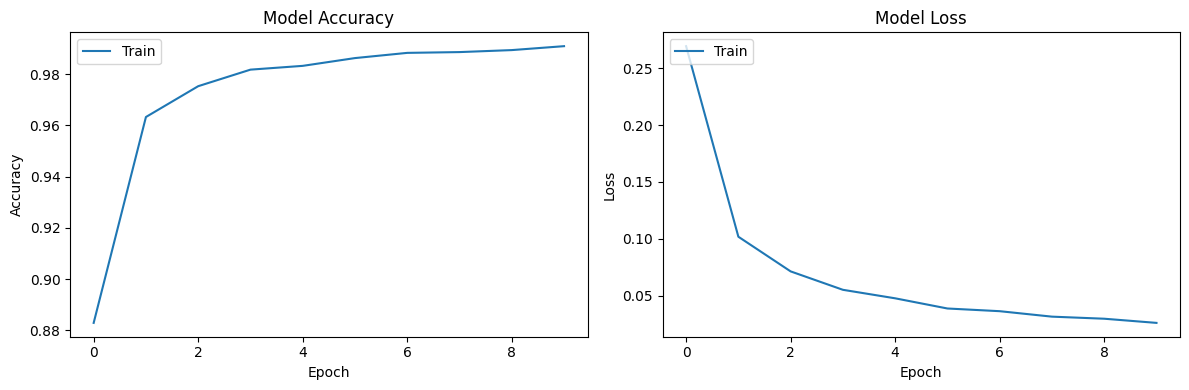

In [105]:
# Plot the accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(BiCNNa_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(BiCNNa_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

In [129]:
# Save all the models
modLSTM.save('models/LSTM.h5')
modBiLSTM.save('models/BiLSTM.h5')
modCNN.save('models/CNN.h5')
modGRU.save('models/GRU.h5')
modAttention.save('models/Attention.h5')
modBILSTMCNN.save('models/BiLSTMCNN.h5')
modBiA.save('models/BiA.h5')
modBiCNA.save('models/BiCNNa.h5')

In [152]:
# manual testing
test = "majority germans want merkel s conservatives fdp greens form govtberlin reuters half germans 57 percent want three way coalition chancellor angela merkel conservatives pro business free democrats fdp greens govern country forsa survey stern magazine showed wednesday merkel conservatives emerged sept 24 national election biggest party need partner partners form government jamaica coalition conservatives fdp greens called black yellow green colors match jamaican flag untested national level shaping likely option social democrats spd junior partners merkel ruling coalition last four years want go opposition suffering worst result since 1933 26 percent germans wanted continuation grand coalition conservatives spd survey 1 003 people conducted sept 28 29 showed"
# test = "susan rice refuses testify senateyou wont believe reason why susan rice announced testify senate russian hacking senator lyndsey graham said disappointed said deal later gave flimsy excuse testifying via lawyer rice considered invitation diversionary play distract attention investigation russian election interference including contacts trump allies russians campaign source said that ridiculous could really want testify oath ya think according cnn barack obama national security adviser turned request sen lindsey graham participate hearing senator whitehouse informed us letter see below agree chairman graham invitation ambassador rice significant departure bipartisan invitations extended witnesses rice lawyer kathryn ruemmler wrote letter graham circumstances ambassador rice respectfully declines senator graham invitation testify rice administration official made dozens requests seeking unmask identities trump associates said national security reasons politically motivated read more daily callerthe letter rice lawyer dear chairman graham ranking member whitehouse i write behalf client ambassador susan e rice response senator graham invitation ambassador rice testify may 8 2017 hearing senate committee judiciary subcommittee crime terrorism entitled russian interference 2016 united states election ambassador rice commends subcommittee efforts examine matter extraordinary national significance extremely rare congress request testimony former senior advisor president given longstanding well recognized separation powers concerns issue moreover chairman graham invitation extended hearing noticed less two weeks hearing scheduled occur without consultation ambassador rice professional courtesy would customarily extended witness notwithstanding significance concerns ambassador rice prepared assist congressional inquiries russian election interference important national interests stake provided conducted bipartisan manner appropriate classified session in case however senator whitehouse informed us letter agree chairman graham invitation ambassador rice significant departure bipartisan invitations extended witnesses circumstances ambassador rice respectfully declines senator graham invitation testify again ambassador rice stated publicly supports committed assisting bipartisan congressional inquiries russian interference 2016 election given utmost importance matter national security please contact questions sincerely kathryn h ruemmler latham watkins llpsusan rice lied numerous times years could forget benghazi rice went 5 morning shows lied cause attack"
# test = "u s citizen run busting bali prisondenpasar indonesia reuters indonesian police hunting u s citizen escaped monday overcrowded prison holiday island bali cutting steel bars ceiling jail second breakout foreign inmates year kerobokan prison 10 km six miles main tourist beaches kuta area often holds foreigners facing drug related charges cristian beasley suspect crimes related narcotics sentenced escaped 4 10 a m 2010 gmt sunday said badung police chief yudith satria hananta thought prisoner escaped cutting steel bars ceiling said statement without giving details beasley escaped without detected beasley 32 california believed used rope climb wall getting perimeter wall area refurbished police questioned witnesses guards hunting beasley hananta said another american paul anthony hoffman 57 captured also trying escape hananta said representatives beasley hoffman could immediately reached comment june australian bulgarian indian malaysian tunneled freedom 12 meters 13 yards prison walls indian bulgarian caught soon neighboring east timor australian shaun edward davidson malaysian tee kok king remain large davidson taunted authorities saying enjoying life various parts world purported posts facebook kerobokan housed number well known foreign drug convicts including australian schappelle corby whose 12 1 2 year sentence marijuana smuggling got huge media attention indonesia executed several foreign drug convicts recent years indonesian prisons often overcrowded partly war drugs led government president joko widodo led surge number people locked up june kerobokan housed 1 378 inmates four times planned capacity 323 government data show prison escapes fairly common indonesia launched investigation year 350 inmates broke prison island sumatra "
# test = "federal judge questions trumps legitimacy attack fellow judge halting muslim banthe judicial branch government getting sick tired donald trump tirades after trump signed unconstitutional executive order banning travelers seven countries entering united states worldwide chaos ensued thousands people detained denied rights attorneys raced rescue federal judge blocked order trump attacking u s district court judge james robart ever since the opinion so called judge essentially takes law enforcement away country ridiculous overturned donald j trump realdonaldtrump february 4 2017what country coming judge halt homeland security travel ban anyone even bad intentions come u s donald j trump realdonaldtrump february 4 2017because ban lifted judge many bad dangerous people may pouring country terrible decision donald j trump realdonaldtrump february 4 2017the judge opens country potential terrorists others best interests heart bad people happy donald j trump realdonaldtrump february 5 2017just cannot believe judge would put country peril something happens blame court system people pouring in bad donald j trump realdonaldtrump february 5 2017if u s win case obviously should never security safety entitled politics donald j trump realdonaldtrump february 8 2017trump literally whining judge robarts decision week acts like judges allowed act check balance executive branch and behavior toward robarts angered one federal judge much calling trump legitimacy question yuuuge deal federal district judge dan polster explained cleveland anti defamation league wednesday explained checks balances exist founding fathers fearful president might want king dictator exactly trump acting polster continued telling audience think federal judge intimidated trump took oath support defend constitution means lot think oath means even today said polster believes trump undermined legitimacy attacking judicial branch halting executive order serious business start calling question legitimacy someone undermines whole system right think say publicly right calls question might even say forfeits legitimacy leave that important question feel call question legitimacy federal district court judge line crossed it trump attacks judicial branch literally starting backfire judges start speak publicly him trump right disagree judges personally attacking disgraces office holds diminishes power executive branch makes trump position look weak desperate could affect decisions judges make future executive orders laws trump signs short trying bully judges good idea read more featured image via andrew harrer pool getty images"
# test = "white house says negotiations continuing border wall fundingwashington reuters negotiations white house congressional leaders spending measure keep u s government running beyond week continuing president donald trump still seeking border wall military funding white house said monday asked trump insisting funding planned border wall current spending measure white house spokesman sean spicer said money military border security wall priority president would take table yet "
test = preprocess_text(test)
test = test.split()
test = model.infer_vector(test)
test = np.array(test).reshape(1, -1)
# test for model
test = modBiLSTM.predict(test)
# it is 2D list so,
print(test[0][0]>.5)

1/1 [==============================] - 0s 21ms/step
True
